#Password Analysis

Great article: https://medium.com/policygenius-stories/the-sophisticates-guide-to-passwords-4bb6b5d9ecb5
        It states password length trumps complexity.  Short passwords already have hash lookups in rainbow tables.

Most common password length: 8 characters.  Special characters seldom used. Commonly used phrases: love, man, wang

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 500)
pd.set_option('display.max_rows', 75)
pd.options.mode.chained_assignment = None     # default='warn'

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# make width of notebook track with width of browser window
from IPython.core.display import HTML
HTML("<style>.container{ width: 100% !important; }</style>")

In [2]:
%%time
# df = pd.read_table('http://datashaping.com/passwords.txt',skiprows=16,names=('A'),quoting=3)  # nrows=10
df = pd.read_csv('pwAnalysis.csv',usecols=['A'])
# df.A[df.A.str.len()>50] # should return nothing
# df.to_csv('pwAnalysis.csv')
# df.info()

totalChar=len(df.A.str.cat())
print('passwords = ',"{:,}".format(df.A.size)
      ,'\ndups = ',df.A.size - df.A.unique().size
      ,'\ntotalCharacters = ',totalChar)

passwords =  2,151,220 
dups =  399 
totalCharacters =  18011567
Wall time: 2.38 s


In [323]:
#how many contain certain string
s = 'windows'
print('people use ',s,
      "{:%}".format(df[df['A'].str.lower().str.match(s,na=False)].size / df.size),' of the time')

df[df['A'].str.lower().str.match(s,na=False)].A.head(25).str.cat(sep='|')

people use  windows 0.013574%  of the time


'windows1|Windows98++|windows|windows03|Windows7|windowssever23|windows1985|windows2k|windows10|windows11|windowsaa|windows789|windowsa|WINDOWS123|windows7|windowshopper|windows1991|windows2006|windowsill4|windowstkm|Windowsxp|windowsucdosa|Windows2004|windowsmonster|windowsxp2'

In [275]:
df5 = pd.DataFrame({'char':['love','pass','man','wang','dragon','zzzz','and','123']})
df5['freq']= df5.char.apply(lambda ch: df[df.A.str.lower().str.match(ch.lower(),na=False)].size)
df5['occurence']= df5.char.apply(lambda ch: df[df.A.str.lower().str.match(ch.lower(),na=False)].size / df.size)
df5.sort_values(by='occurence',ascending=False)

,char,freq,occurence
7,123,11887,0.005526
3,wang,5135,0.002387
0,love,4739,0.002203
2,man,3623,0.001684
6,and,2429,0.001129
1,pass,1812,0.000842
4,dragon,648,0.000301
5,zzzz,112,0.000052


most common length:  8.0 characters


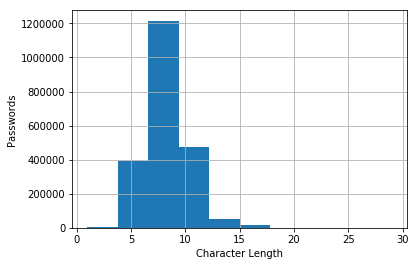

In [33]:
df['pwlength']=df.A.str.len()
pp = df['pwlength'].hist()
z = pp.set_xlabel("Character Length")
z = pp.set_ylabel("Passwords")
print('most common length: ',df['pwlength'].mode().max(), 'characters')

In [34]:
# how often are special case used?
df['specialChar']=df.A.apply(lambda s: not str(s).isalnum())
# df.A[df['specialChar']==True].head(50).str.cat(sep='|')  # print some passwords containing special characters
print('people use special characters ', "{:%}".format(df.A[df['specialChar']==True].size / df.A.size),'of the time')

people use special characters  3.104471% of the time


In [90]:
# what alpha character is most often used?
import nltk

def printMostCommon(n):
    df2 = pd.DataFrame(fdist.most_common(n))
    df2.columns = ['char','freq']
    df2['occurence']= df2.freq / len(df.A.str.cat()) 
    return df2
    
fdist = nltk.FreqDist(ch.lower() for ch in df.A.str.cat() if ch.isalpha())
printMostCommon(3)[['char','occurence']]

,char,occurence
0,a,0.059467
1,e,0.045304
2,i,0.040045


In [96]:
#most common digits
fdist = nltk.FreqDist(ch.lower() for ch in df.A.str.cat() if ch.isdigit())
print(printMostCommon(10)[['char','occurence']].to_string(index=False))
# df2.loc[:,['char','freq']

char  occurence
  1   0.070659
  0   0.055075
  2   0.052167
  3   0.040011
  8   0.039114
  9   0.037986
  5   0.036266
  6   0.033089
  7   0.031876
  4   0.031412


In [93]:
#most common special character
fdist = nltk.FreqDist(ch.lower() for ch in df.A.str.cat() if not ch.isalnum())
printMostCommon(8)[['char','occurence']]

,char,occurence
0,.,0.001021
1,@,0.000675
2,!,0.000595
3,-,0.000428
4,_,0.000423
5,*,0.000357
6,#,0.000260
7,,0.000232


In [60]:
import datetime

def printTimeDuration (msg):
    global dtStart, dtLast
    dtNow = datetime.datetime.now()
    cumDelta = dtNow - dtStart
    curDelta = dtNow - dtLast
    
    hours, remainder = divmod(curDelta.seconds, 3600)
    minutes, seconds = divmod(remainder, 60)

    cumHours, cumRemainder = divmod(cumDelta.seconds, 3600)
    cumMinutes, cumSeconds = divmod(cumRemainder, 60)
    
    print(msg,'incr:','%s:%s:%s' % (hours, minutes, seconds),'ttl:','%s:%s:%s' % (cumHours, cumMinutes, cumSeconds))
    dtLast = dtNow

In [351]:
%%prun
# what character combo is most often used?

import re
import math
from collections import Counter

def mostCommonStrings(charLen,cnt):
    s=df.A.head(10000).str.cat()
#     s=df.A.str.cat()

    t = len(s) - (charLen - 1)
    for i in range(t):
        char = s[i:i+charLen]               # a sequence of characters being considered
        allAlpha = True
        for j in range(charLen):
            if not char[j].isalpha():
                allAlpha = False
                break
        if allAlpha:
            numFound = len(re.findall(char,s))
            if numFound>8 and not cnt[char]:
                cnt[char] += numFound

    printTimeDuration('charLen'+str(charLen))
    return cnt

# for timing
dtStart = datetime.datetime.now()
dtLast = dtStart
printTimeDuration('start')
    
cnt = Counter()
for i in range(4,9):
    cnt = mostCommonStrings(i,cnt)

df3 = pd.DataFrame.from_dict(cnt, orient='index').reset_index()
if df3.columns.size==2:
    df3.columns = ['char','freq']
    #df3['freq']=df3.freq.apply(lambda x: math.sqrt(x))
    df3['charLen']=df3.char.apply(lambda str: len(str))
print('records=',df3.size)

records= 306
 

In [324]:
# df2.drop(df.index, inplace=True)
# df2 = df2.iloc[0:0].copy()
cnt['love']

574

168

In [ ]:
# df3[df3.charLen==8].sort_values('freq',ascending=False).head(25)
#remove those found with higher frequency
#add column if found in english

# df4 = df3.copy()
# df4.sort_values('freq',ascending=False).head(10)
# df4.to_csv('pwpatterns.csv')
# df4 = pd.read_csv('pwpatterns.csv',usecols=['char','freq','charLen'])


In [339]:
s=df.A.head(10000).str.cat()
len(re.findall('gun',s))

6

In [335]:
len(df.A.head(50000).str.cat()) /  len(df.A.str.cat())

0.02321091773969472

In [66]:
df4['small']=False

# for timing
# dtStart = datetime.datetime.now()
# dtLast = dtStart
# printTimeDuration('start')

#cols 0..:0 char, 1 freq, 2 charLen, 3 small
# for i in df4.index:
#     if i % 100 == 0: printTimeDuration(i)  
#     charLen = df4.iat[i,2]
#     for j in df4.index:
#         if df4.iat[j,0][0:charLen] == df4.iat[i,0] and df4.iat[j,2] > charLen:
#             df4.iat[i,3]=True

# df4[df4.char=='acces']
# df4[df4.char=='access']

# df4.sort_values('char',ascending=True).head(100)
print('finished')

finished


In [ ]:
2+4

In [49]:
#cols 0..:0 char, 1 freq, 2 charLen, 3 small
# df4.iat[6892,3]
# df4.iloc[6892]
# df4[df4.char=='acces']


True

char       acces
freq           9
charLen        5
small       True
Name: 6892, dtype: object

,char,freq,charLen,small
6892,acces,9,5,True
